In [1]:
import numpy as np
import glob
import h5py

import matplotlib
matplotlib.use("Agg")

import matplotlib.pyplot as plt
%matplotlib inline

import gwpy
from gwpy import segments
from gwpy.timeseries import TimeSeries
from gwpy.timeseries import (StateTimeSeries, StateVector)
import gwpy.astro

import json

from scipy.interpolate import interp1d
from astropy import cosmology, units as u
from pycbc.filter import matched_filter, highpass, lowpass, sigma, resample_to_delta_t
from pycbc.psd import interpolate, inverse_spectrum_truncation, welch
from pycbc.types.frequencyseries import FrequencySeries

from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
from pycbc.psd import interpolate

from tqdm import tqdm
# import ligo.skymap.plot

/home/chihyi.chang/miniconda3/envs/igwn-py310/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/home/chihyi.chang/miniconda3/envs/igwn-py310/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this p

lal.MSUN_SI != Msun


# Read PSD and Raw Data from CIT
## GW250114

In [ ]:
def read_psd(filename, delimiter=" "):
    data = np.loadtxt(filename, delimiter=delimiter)
    freqs = data[:,0]
    value = data[:,1]

    fs = FrequencySeries(value, delta_f=freqs[1])

    return fs

## Read seqARIMA PSD

In [34]:
file_dir = "/home/chihyi.chang/data/beacon_data/"
PSD_p4k = {}
PSD_p8k = {}
PSD_p8k_q3 = {}

ifos = ["H1", "L1"]
for ifo in ifos:
    PSD_p4k[ifo] = read_psd(f"{file_dir}/PSD_{ifo}_p4k.dat")
    PSD_p8k[ifo] = read_psd(f"{file_dir}/PSD_{ifo}_p8k.dat")
    PSD_p8k_q3[ifo] = read_psd(f"{file_dir}/PSD_{ifo}_p8k_q3.dat")

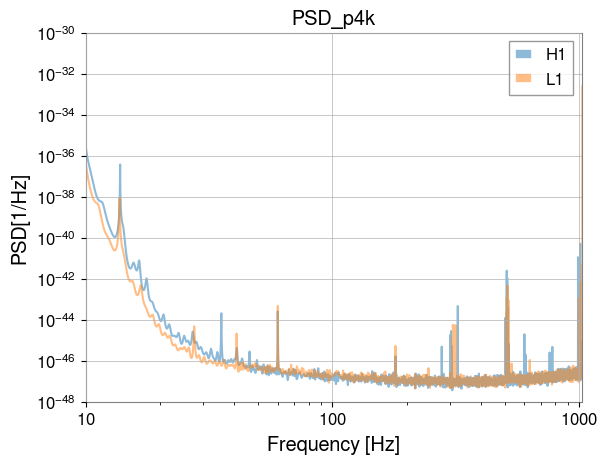

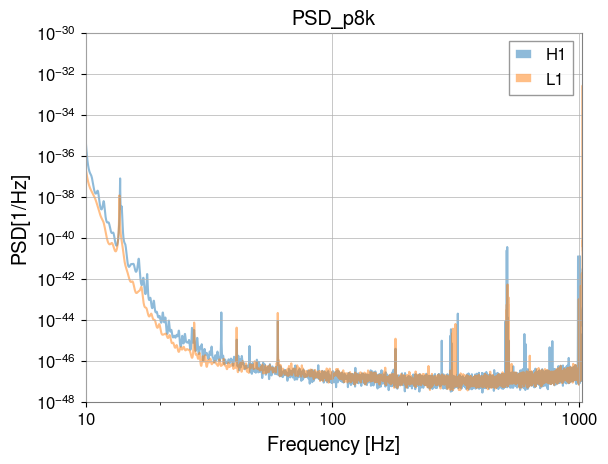

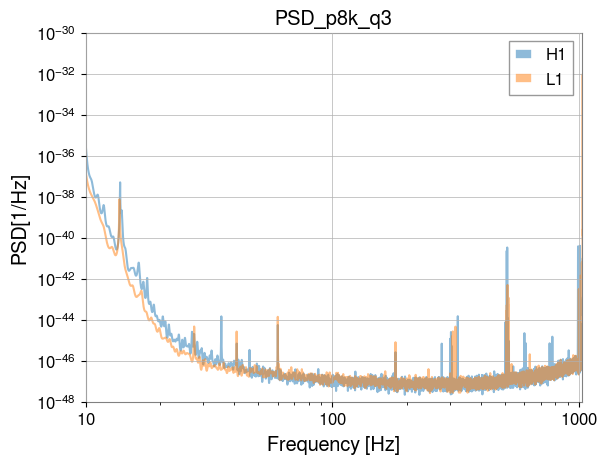

In [35]:
for ifo in ifos:
    plt.plot(PSD_p4k[ifo].sample_frequencies, PSD_p4k[ifo], label=ifo, alpha=0.5)
    plt.title("PSD_p4k")

    plt.xlim(10, 1024)
    plt.ylim(1e-48, 1e-30)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD[1/Hz]')
    plt.legend()
plt.show()

for ifo in ifos:
    plt.plot(PSD_p8k[ifo].sample_frequencies, PSD_p8k[ifo], label=ifo, alpha=0.5)
    plt.title("PSD_p8k")

    plt.xlim(10, 1024)
    plt.ylim(1e-48, 1e-30)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD[1/Hz]')
    plt.legend()
plt.show()

for ifo in ifos:
    plt.plot(PSD_p8k_q3[ifo].sample_frequencies, PSD_p8k_q3[ifo], label=ifo, alpha=0.5)
    plt.title("PSD_p8k_q3")

    plt.xlim(10, 1024)
    plt.ylim(1e-48, 1e-30)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD[1/Hz]')
    plt.legend()
plt.show()


## Download Raw Data

In [12]:
import glob

from gwpy.timeseries import TimeSeries
# gps time: 1420878141.22
# The directory of data
gps_time = 1420878141.22
ifos = ["L1", "H1"]
time_label = 142
strains = {}
state_ts = {}
for ifo in ifos:
    data_dir = (
    f"/archive/frames/O4/hoft_C00_AR/{ifo}/{ifo[0]}-{ifo}_HOFT_C00_AR-{time_label}"
    )
    gwfs = glob.glob(f"{data_dir}/*.gwf")
    channel = f"{ifo}:GDS-CALIB_STRAIN_AR"
    channel = f"{ifo}:GDS-CALIB_STRAIN_CLEAN_AR"
    print(f"get file directory, total {len(gwfs)} files")

    # Read strain data
    print(f"start get timeseries")
    start, end = 1420878061, 1420878149
    strains[ifo] = TimeSeries.read(
    source=gwfs,
    channel=channel,
    start=start,
    end=end,
    )

    state_channel = f"{ifo}:GDS-CALIB_STATE_VECTOR_AR"
    state_ts[ifo] = StateVector.read(
        source=gwfs,
        channel=state_channel,
        start=start ,
        end=end,
        bits=["Bit 0", "Bit 1"]
    )
    print(f"{strains[ifo].duration}")

get file directory, total 1420 files
start get timeseries
88.0 s
get file directory, total 1534 files
start get timeseries
88.0 s


# Check Data Quality

In [13]:
for ifo in ifos:
    bit_dict = state_ts[ifo].get_bit_series(bits=["Bit 0", "Bit 1"])
    print((bit_dict["Bit 0"]*bit_dict["Bit 1"]).all())

True
True


# Prepare Template

In [20]:
approximant = 'SEOBNRv4_ROM'
mass1 = 36.918
mass2 = 34.913
spin1x = 0.0
spin1y = 0.0
spin1z = -0.012
spin2x = 0.0
spin2y = 0.0
spin2z = -0.028
sample_rate = 4096

hp_templates = []

hp, hc = get_td_waveform(approximant=approximant, 
                            mass1 = mass1, 
                            mass2 = mass2, 
                            spin1x = spin1x,
                            spin1y = spin1y,
                            spin1z = spin1z, 
                            spin2x = spin2x,
                            spin2y = spin2y,
                            spin2z = spin2z, 
                            delta_t = 1/sample_rate,
                            f_lower=10
                            )
template_hp = hp.copy()
template_hc = hc.copy()

hp_templates.append(template_hp)

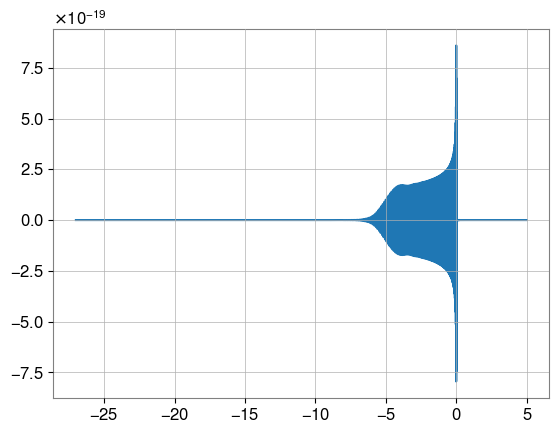

In [21]:
plt.plot(hp_templates[0].sample_times, hp_templates[0])
plt.show()

# Match filtering

## Original Method

In [23]:
# l1_gps_time = 1435447084.927124023
# l1_merge_ind = np.argwhere(strains["K1"].times.value > l1_gps_time)[0]

# st = int(l1_merge_ind) - 10*16384
# ed = st + 20*16384

original_SNR_ts = {}
sample_rate = 4096
for ifo in ifos:
    cal_psd_ts = strains[ifo].copy().crop(strains[ifo].t0.value,strains[ifo].t0.value+64).to_pycbc()
    ifo_strain = strains[ifo].copy().crop(strains[ifo].t0.value+72, strains[ifo].t0.value+88).to_pycbc()
    ifo_strain = highpass(ifo_strain, 10).resample(1.0/sample_rate)
    ifo_strain = ifo_strain.crop(3, 3)
    print(ifo_strain.duration)

    psd = cal_psd_ts.psd(8)
    psd = interpolate(psd, ifo_strain.delta_f)

    hp_template = hp_templates[0].copy()
    st_crop = -5 - hp_template.sample_times[0]
    ed_crop = hp_template.sample_times[-1] - 5 + 1.0/sample_rate
    hp_template = hp_template.crop(st_crop, ed_crop)
    hp_template = hp_template.cyclic_time_shift(float(hp_template.start_time))

    crop = 2
    hp_only_snr_ts = matched_filter(hp_template,ifo_strain, psd=psd, low_frequency_cutoff=10)
    original_SNR_ts[ifo] = hp_only_snr_ts.crop(crop, crop)

10.0
10.0


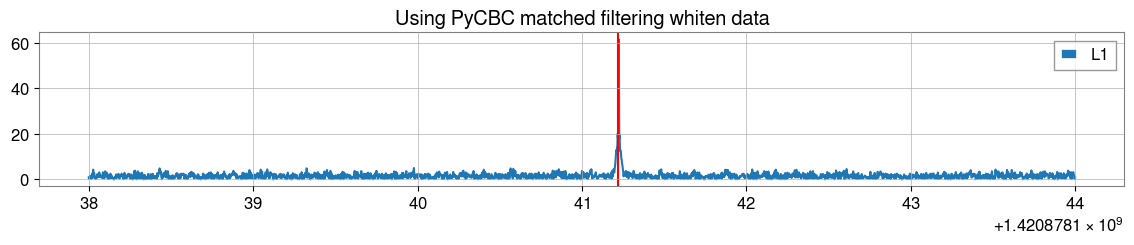

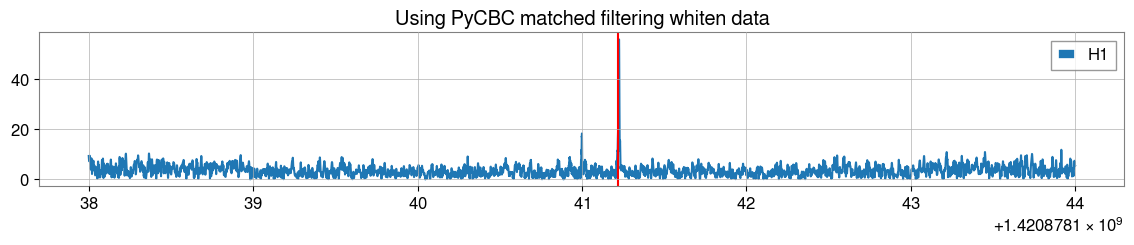

In [24]:
for ifo in ifos:
    plt.figure(figsize=(14, 2))
    plt.plot(original_SNR_ts[ifo].sample_times, abs(original_SNR_ts[ifo]), label=ifo)
    plt.axvline(gps_time, color='r')

    plt.title("Using PyCBC matched filtering whiten data")
    plt.legend()
    plt.show()

## Whitening case to calculate SNR Timeseries
1. whiten raw data: $\frac{d_{raw}(f)}{\surd(psd)}$  
2. whiten template: $\frac{d_{template}(f)}{\surd(psd)}$  
3. set up PSD into 1  

In [25]:
white_SNR_ts = {}
for ifo in ifos:
    cal_psd_ts = strains[ifo].copy().crop(strains[ifo].t0.value,strains[ifo].t0.value+64).to_pycbc()
    ifo_strain = strains[ifo].copy().crop(strains[ifo].t0.value+72, strains[ifo].t0.value+88).to_pycbc()
    ifo_strain = resample_to_delta_t(highpass(ifo_strain, 10),1.0/sample_rate).crop(3, 3)

    psd = cal_psd_ts.psd(8)
    psd = interpolate(psd, ifo_strain.delta_f)

    f_ifo_strain = ifo_strain.to_frequencyseries()
    # f_ifo_strain = f_ifo_strain / psd[:len(f_ifo_strain)]**0.5
    ifo_strain = (f_ifo_strain / psd[:len(f_ifo_strain)]**0.5).to_timeseries()
    # ifo_strain = highpass(ifo_strain, 10).resample(1.0/sample_rate)
    # ifo_strain = ifo_strain.crop(3, 3)

    # whiten template
    hp_template = hp_templates[0].copy()
    f_hp_template = hp_template.to_frequencyseries()
    template_whiten_psd = interpolate(psd, f_hp_template.delta_f)
    # f_hp_template = f_hp_template / template_whiten_psd[:len(f_hp_template)]
    # print(len(f_hp_template))
    # f_hp_template = interpolate(f_hp_template, f_ifo_strain.delta_f)
    hp_template = (f_hp_template / template_whiten_psd[:len(f_hp_template)]**0.5).to_timeseries()
    # print(len(f_hp_template))

    st_crop = -5 - hp_template.sample_times[0]
    ed_crop = hp_template.sample_times[-1] - 5 + 1.0/sample_rate
    hp_template = hp_template.crop(st_crop, ed_crop)
    hp_template = hp_template.cyclic_time_shift(float(hp_template.start_time))
    
    crop = 2
    SNR_ts = matched_filter(hp_template,ifo_strain, psd=None, low_frequency_cutoff=10)
    white_SNR_ts[ifo] = SNR_ts.crop(crop, crop)

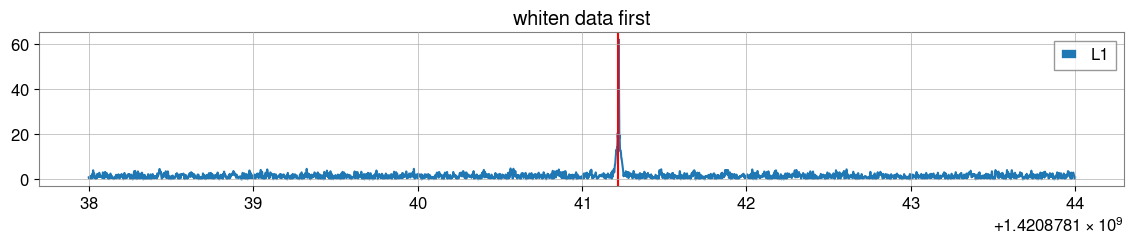

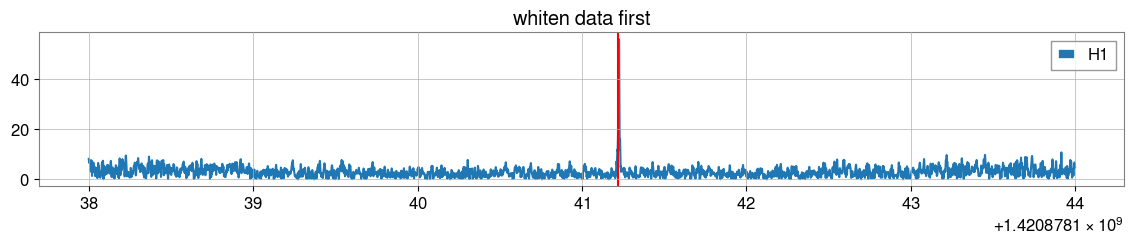

In [26]:
for ifo in ifos:
    plt.figure(figsize=(14, 2))
    plt.plot(white_SNR_ts[ifo].sample_times, abs(white_SNR_ts[ifo]), label=ifo)
    plt.axvline(gps_time, color='r')

    plt.title("whiten data first")
    plt.legend()
    plt.show()

## Compare whiten first and pycbc matched filtering whiten

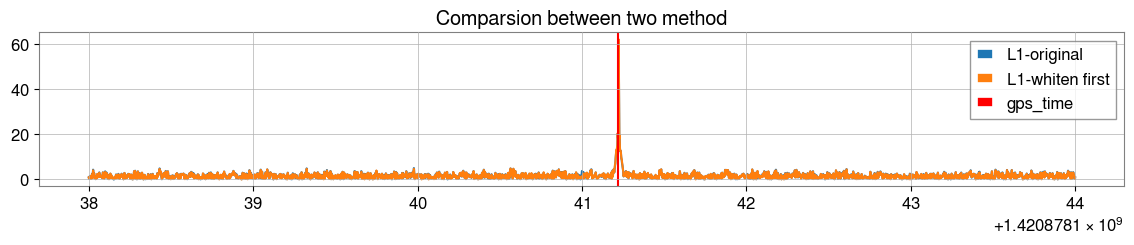

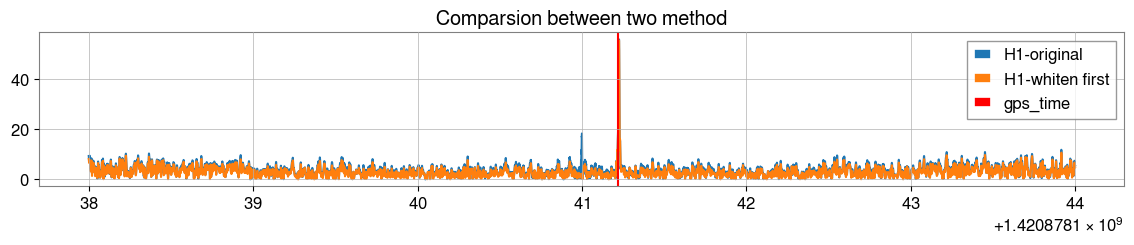

In [27]:
for ifo in ifos:
    plt.figure(figsize=(14, 2))
    plt.plot(original_SNR_ts[ifo].sample_times, abs(original_SNR_ts[ifo]), label=f"{ifo}-original")
    plt.plot(white_SNR_ts[ifo].sample_times, abs(white_SNR_ts[ifo]), label=f"{ifo}-whiten first")
    plt.axvline(gps_time, color='r', label="gps_time")

    plt.title("Comparsion between two method")
    plt.legend()
    plt.show()

## Using seqARIMA PSD to calculate matched filtering

In [28]:
# l1_gps_time = 1435447084.927124023
# l1_merge_ind = np.argwhere(strains["K1"].times.value > l1_gps_time)[0]

# st = int(l1_merge_ind) - 10*16384
# ed = st + 20*16384

seqARIMA_snr_ts_p4k = {}
seqARIMA_snr_ts_p8k = {}
seqARIMA_snr_ts_p8k_q3 = {}

sample_rate = 4096
for ifo in ifos:
    ifo_strain = strains[ifo].copy().crop(strains[ifo].t0.value+72, strains[ifo].t0.value+88).to_pycbc()
    # ifo_strain = ifo_strain.resample(1.0/sample_rate)
    ifo_strain = highpass(ifo_strain, 10).resample(1.0/sample_rate)
    ifo_strain = ifo_strain.crop(3, 3)
    print(ifo_strain.duration)

    psd_p4k = PSD_p4k[ifo]
    psd_p4k = interpolate(psd_p4k, ifo_strain.delta_f)
    psd_p8k = PSD_p8k[ifo]
    psd_p8k = interpolate(psd_p8k, ifo_strain.delta_f)
    psd_p8k_q3 = PSD_p8k_q3[ifo]
    psd_p8k_q3 = interpolate(psd_p8k_q3, ifo_strain.delta_f)

    hp_template = hp_templates[0].copy()
    st_crop = -5 - hp_template.sample_times[0]
    ed_crop = hp_template.sample_times[-1] - 5 + 1.0/sample_rate
    hp_template = hp_template.crop(st_crop, ed_crop)
    hp_template = hp_template.cyclic_time_shift(float(hp_template.start_time))

    crop = 2
    hp_only_snr_ts = matched_filter(hp_template,ifo_strain, psd=psd_p4k, low_frequency_cutoff=10)
    seqARIMA_snr_ts_p4k[ifo] = hp_only_snr_ts.crop(crop, crop)

    hp_only_snr_ts = matched_filter(hp_template,ifo_strain, psd=psd_p8k, low_frequency_cutoff=10)
    seqARIMA_snr_ts_p8k[ifo] = hp_only_snr_ts.crop(crop, crop)
    
    hp_only_snr_ts = matched_filter(hp_template,ifo_strain, psd=psd_p8k_q3, low_frequency_cutoff=10)
    seqARIMA_snr_ts_p8k_q3[ifo] = hp_only_snr_ts.crop(crop, crop)


10.0


10.0


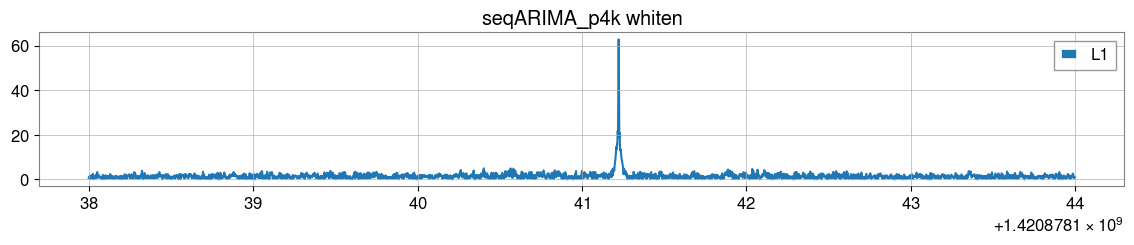

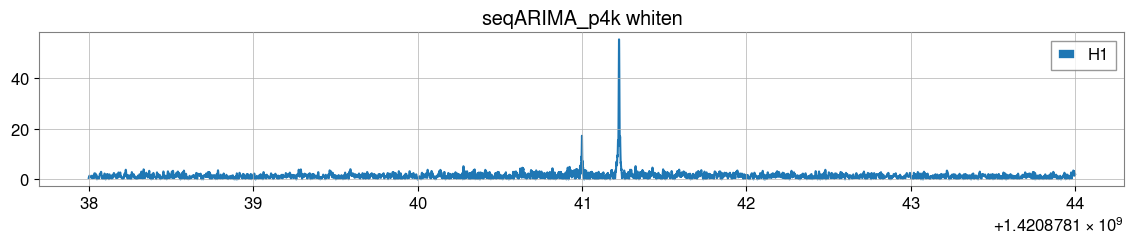

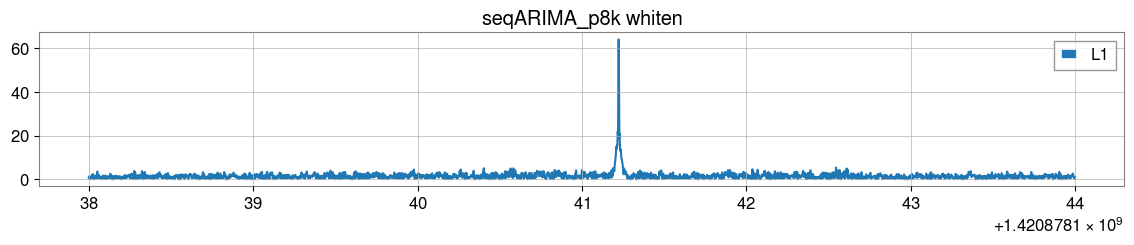

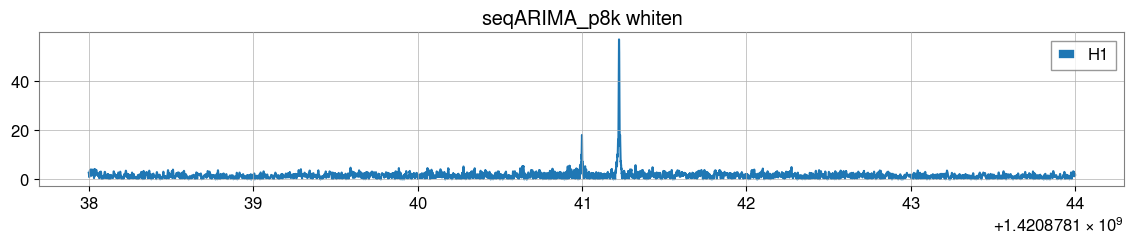

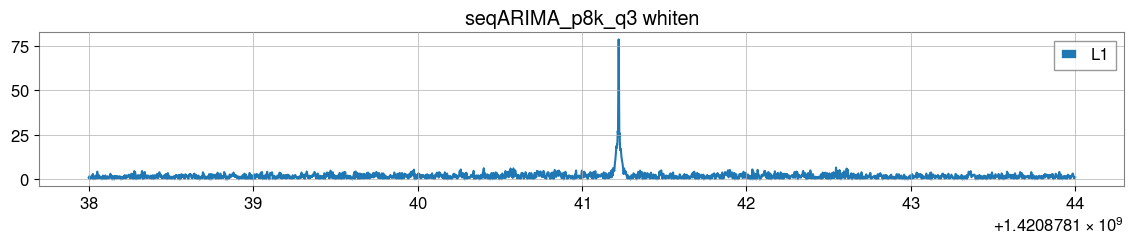

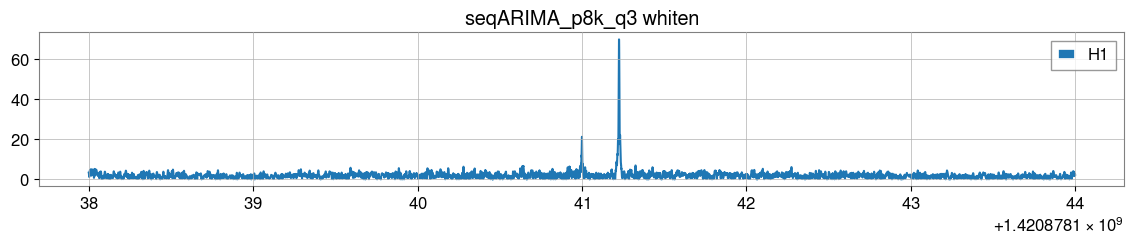

In [29]:
for ifo in ifos:
    plt.figure(figsize=(14, 2))
    plt.plot(seqARIMA_snr_ts_p4k[ifo].sample_times, abs(seqARIMA_snr_ts_p4k[ifo]), label=ifo)
    # plt.axvline(gps_time, color='r')

    plt.title("seqARIMA_p4k whiten")
    plt.legend()
plt.show()

for ifo in ifos:
    plt.figure(figsize=(14, 2))
    plt.plot(seqARIMA_snr_ts_p8k[ifo].sample_times, abs(seqARIMA_snr_ts_p8k[ifo]), label=ifo)
    # plt.axvline(gps_time, color='r')

    plt.title("seqARIMA_p8k whiten")
    plt.legend()
plt.show()

for ifo in ifos:
    plt.figure(figsize=(14, 2))
    plt.plot(seqARIMA_snr_ts_p8k_q3[ifo].sample_times, abs(seqARIMA_snr_ts_p8k_q3[ifo]), label=ifo)
    # plt.axvline(gps_time, color='r')

    plt.title("seqARIMA_p8k_q3 whiten")
    plt.legend()
plt.show()

## Compare seqARIMA PSD and whiten

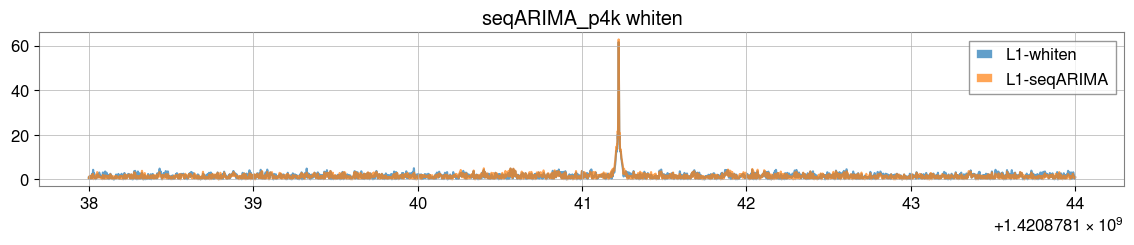

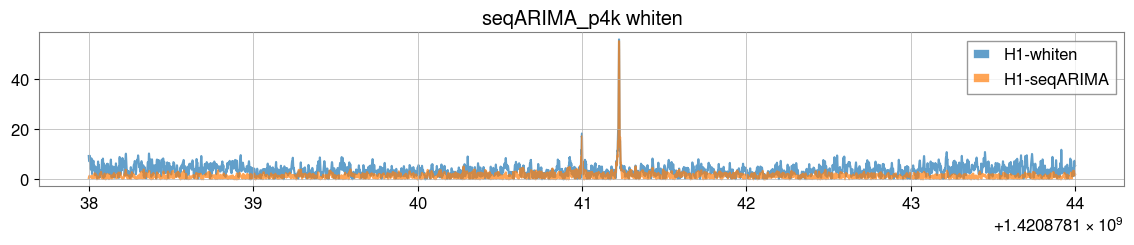

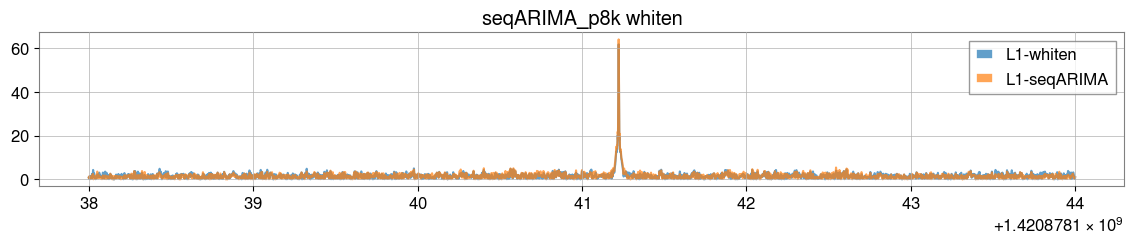

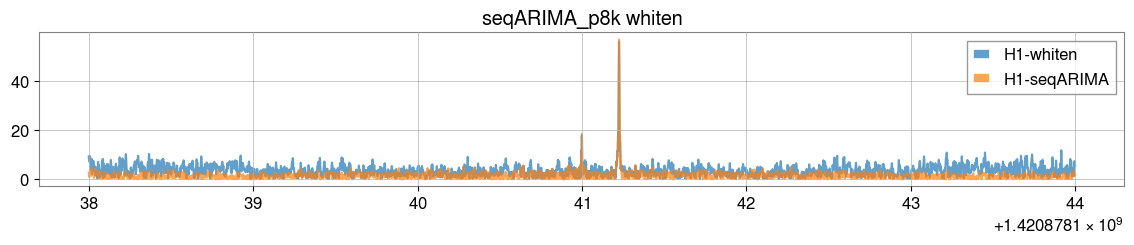

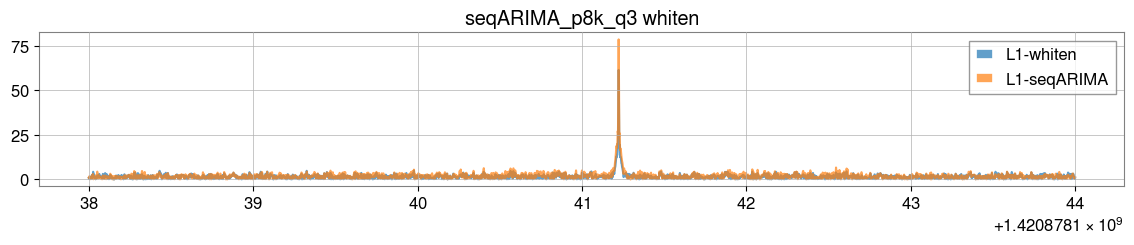

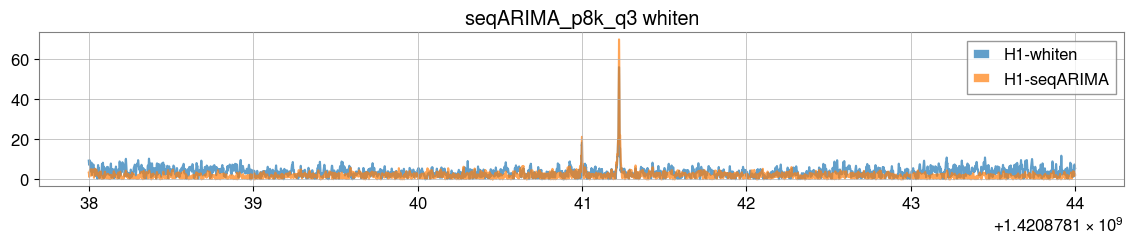

In [30]:
for ifo in ifos:
    plt.figure(figsize=(14, 2))
    plt.plot(original_SNR_ts[ifo].sample_times, abs(original_SNR_ts[ifo]), label=f"{ifo}-whiten", alpha=0.7)
    plt.plot(seqARIMA_snr_ts_p4k[ifo].sample_times, abs(seqARIMA_snr_ts_p4k[ifo]), label=f"{ifo}-seqARIMA", alpha=0.7)
    # plt.axvline(gps_time, color='r')

    plt.title("seqARIMA_p4k whiten")
    plt.legend()
plt.show()

for ifo in ifos:
    plt.figure(figsize=(14, 2))
    plt.plot(original_SNR_ts[ifo].sample_times, abs(original_SNR_ts[ifo]), label=f"{ifo}-whiten", alpha=0.7)
    plt.plot(seqARIMA_snr_ts_p8k[ifo].sample_times, abs(seqARIMA_snr_ts_p8k[ifo]), label=f"{ifo}-seqARIMA", alpha=0.7)
    # plt.axvline(gps_time, color='r')

    plt.title("seqARIMA_p8k whiten")
    plt.legend()
plt.show()

for ifo in ifos:
    plt.figure(figsize=(14, 2))
    plt.plot(original_SNR_ts[ifo].sample_times, abs(original_SNR_ts[ifo]), label=f"{ifo}-whiten", alpha=0.7)
    plt.plot(seqARIMA_snr_ts_p8k_q3[ifo].sample_times, abs(seqARIMA_snr_ts_p8k_q3[ifo]), label=f"{ifo}-seqARIMA", alpha=0.7)
    # plt.axvline(gps_time, color='r')

    plt.title("seqARIMA_p8k_q3 whiten")
    plt.legend()
plt.show()

# Save SNR timeseries and PSD

819


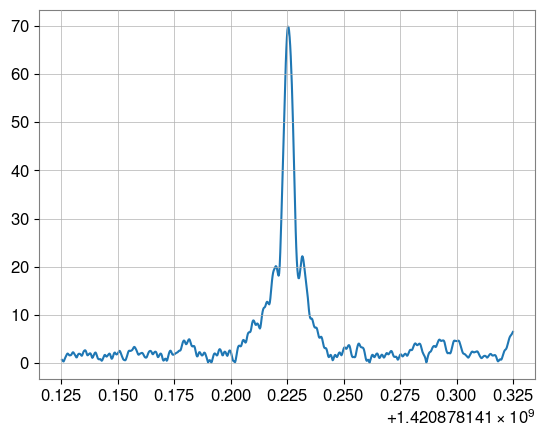

In [31]:
ifo = "H1"
gps_ind = int(np.argmin(np.abs(seqARIMA_snr_ts_p8k_q3[ifo].sample_times - gps_time)))
closest_time = float(seqARIMA_snr_ts_p8k_q3[ifo].sample_times[gps_ind])
sample_rate = seqARIMA_snr_ts_p8k_q3[ifo].sample_rate

time_before_gps, time_after_gps = 1, 1
res_snr_ts = seqARIMA_snr_ts_p8k_q3[ifo][gps_ind-int(time_before_gps*sample_rate): gps_ind+int(time_after_gps*sample_rate)]
max_ind = np.argmax(abs(res_snr_ts))

res_time_before_merge, res_time_after_merge = 0.1, 0.1
res_snr_ts = res_snr_ts[max_ind-int(sample_rate*res_time_before_merge)-1:max_ind+int(sample_rate*res_time_before_merge)]
print(len(res_snr_ts))
plt.plot(res_snr_ts.sample_times, abs(res_snr_ts))
plt.show()

819
819


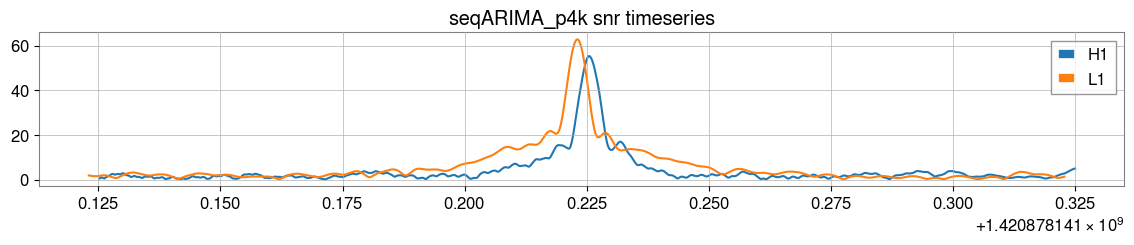

In [47]:
res_snr_ts_p4k = {}
merger_time_p4k = {}

plt.figure(figsize=(14, 2))
for ifo in ifos:
    gps_ind = int(np.argmin(np.abs(seqARIMA_snr_ts_p4k[ifo].sample_times - gps_time)))
    closest_time = float(seqARIMA_snr_ts_p4k[ifo].sample_times[gps_ind])
    sample_rate = seqARIMA_snr_ts_p4k[ifo].sample_rate

    time_before_gps, time_after_gps = 1, 1
    res_snr_ts_p4k_ = seqARIMA_snr_ts_p4k[ifo][gps_ind-int(time_before_gps*sample_rate): gps_ind+int(time_after_gps*sample_rate)]
    max_ind = np.argmax(abs(res_snr_ts_p4k_))
    merger_time_p4k[ifo] = res_snr_ts_p4k_.sample_times[max_ind]

    res_time_before_merge, res_time_after_merge = 0.1, 0.1
    res_snr_ts_p4k[ifo] = res_snr_ts_p4k_[max_ind-int(sample_rate*res_time_before_merge)-1:max_ind+int(sample_rate*res_time_before_merge)]
    print(len(res_snr_ts_p4k[ifo]))
    plt.plot(res_snr_ts_p4k[ifo].sample_times, abs(res_snr_ts_p4k[ifo]), label=ifo)

plt.title("seqARIMA_p4k snr timeseries")
plt.legend()
plt.show()

819
819


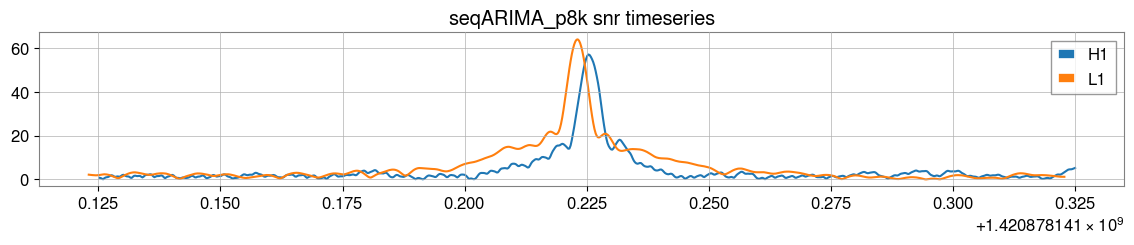

In [48]:
res_snr_ts_p8k = {}
merger_time_p8k = {}

plt.figure(figsize=(14, 2))
for ifo in ifos:
    gps_ind = int(np.argmin(np.abs(seqARIMA_snr_ts_p8k[ifo].sample_times - gps_time)))
    closest_time = float(seqARIMA_snr_ts_p8k[ifo].sample_times[gps_ind])
    sample_rate = seqARIMA_snr_ts_p8k[ifo].sample_rate

    time_before_gps, time_after_gps = 1, 1
    res_snr_ts_p8k_ = seqARIMA_snr_ts_p8k[ifo][gps_ind-int(time_before_gps*sample_rate): gps_ind+int(time_after_gps*sample_rate)]
    max_ind = np.argmax(abs(res_snr_ts_p8k_))
    merger_time_p8k[ifo] = res_snr_ts_p8k_.sample_times[max_ind]

    res_time_before_merge, res_time_after_merge = 0.1, 0.1
    res_snr_ts_p8k[ifo] = res_snr_ts_p8k_[max_ind-int(sample_rate*res_time_before_merge)-1:max_ind+int(sample_rate*res_time_before_merge)]
    print(len(res_snr_ts_p8k[ifo]))
    plt.plot(res_snr_ts_p8k[ifo].sample_times, abs(res_snr_ts_p8k[ifo]), label=ifo)

plt.title("seqARIMA_p8k snr timeseries")
plt.legend()
plt.show()

819
819


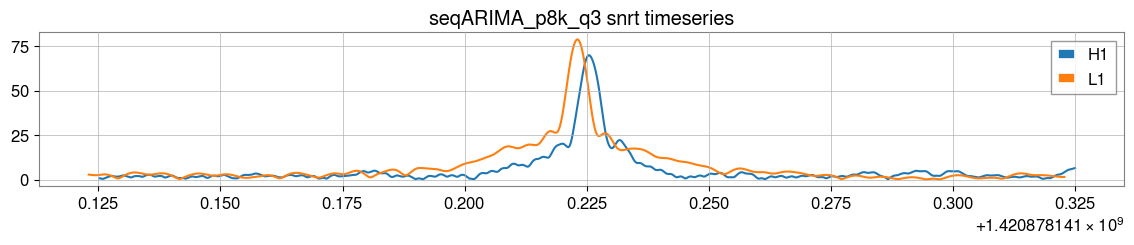

In [49]:
res_snr_ts = {}
merger_time = {}

plt.figure(figsize=(14, 2))
for ifo in ifos:
    gps_ind = int(np.argmin(np.abs(seqARIMA_snr_ts_p8k_q3[ifo].sample_times - gps_time)))
    closest_time = float(seqARIMA_snr_ts_p8k_q3[ifo].sample_times[gps_ind])
    sample_rate = seqARIMA_snr_ts_p8k_q3[ifo].sample_rate

    time_before_gps, time_after_gps = 1, 1
    res_snr_ts_ = seqARIMA_snr_ts_p8k_q3[ifo][gps_ind-int(time_before_gps*sample_rate): gps_ind+int(time_after_gps*sample_rate)]
    max_ind = np.argmax(abs(res_snr_ts_))
    merger_time[ifo] = res_snr_ts_.sample_times[max_ind]

    res_time_before_merge, res_time_after_merge = 0.1, 0.1
    res_snr_ts[ifo] = res_snr_ts_[max_ind-int(sample_rate*res_time_before_merge)-1:max_ind+int(sample_rate*res_time_before_merge)]
    print(len(res_snr_ts[ifo]))
    plt.plot(res_snr_ts[ifo].sample_times, abs(res_snr_ts[ifo]), label=ifo)

plt.title("seqARIMA_p8k_q3 snrt timeseries")
plt.legend()
plt.show()

In [50]:
with h5py.File("/home/chihyi.chang/Bayestar/large_real_event/GW250114/coinc_gw250114_p8k_q3.hdf", "w") as hf:
    event = hf.create_group("event")
    Parameters = event.create_group("Parameters")
    SNR_ts = event.create_group("SNR_ts")
    PSD = event.create_group("PSD")

    Parameters.create_dataset("Mass1", data=mass1)
    Parameters.create_dataset("Mass2", data=mass2)
    Parameters.create_dataset("Spin1x", data=spin1x)
    Parameters.create_dataset("Spin1y", data=spin1y)
    Parameters.create_dataset("Spin1z", data=spin1z)
    Parameters.create_dataset("Spin2x", data=spin2x)
    Parameters.create_dataset("Spin2y", data=spin2y)
    Parameters.create_dataset("Spin2z", data=spin2z)

    SNR_ts.create_dataset("L1-SNR_ts", data=res_snr_ts["L1"])
    SNR_ts.create_dataset("H1-SNR_ts", data=res_snr_ts["H1"])
    SNR_ts.create_dataset("L1-merger_time", data=merger_time["L1"])
    SNR_ts.create_dataset("H1-merger_time", data=merger_time["H1"])
    SNR_ts.create_dataset("L1-start_time", data=res_snr_ts["L1"].sample_times[0])
    SNR_ts.create_dataset("H1-start_time", data=res_snr_ts["H1"].sample_times[0])
    SNR_ts.create_dataset("sampling_rate", data=res_snr_ts["L1"].sample_rate)

    PSD.create_dataset("L1-PSD", data=PSD_p8k_q3["L1"])
    PSD.create_dataset("H1-PSD", data=PSD_p8k_q3["H1"])
    PSD.create_dataset("L1-start_time", data=res_snr_ts["L1"].sample_times[0])
    PSD.create_dataset("H1-start_time", data=res_snr_ts["H1"].sample_times[0])
    PSD.create_dataset("L1-sampling_frequency", data=1/PSD_p8k_q3["L1"].sample_frequencies[1])
    PSD.create_dataset("H1-sampling_frequency", data=1/PSD_p8k_q3["H1"].sample_frequencies[1])
    PSD.create_dataset("f0", data=PSD_p8k_q3["L1"].sample_frequencies[0])


In [51]:
with h5py.File("/home/chihyi.chang/Bayestar/large_real_event/GW250114/coinc_gw250114_p8k.hdf", "w") as hf:
    event = hf.create_group("event")
    Parameters = event.create_group("Parameters")
    SNR_ts = event.create_group("SNR_ts")
    PSD = event.create_group("PSD")

    Parameters.create_dataset("Mass1", data=mass1)
    Parameters.create_dataset("Mass2", data=mass2)
    Parameters.create_dataset("Spin1x", data=spin1x)
    Parameters.create_dataset("Spin1y", data=spin1y)
    Parameters.create_dataset("Spin1z", data=spin1z)
    Parameters.create_dataset("Spin2x", data=spin2x)
    Parameters.create_dataset("Spin2y", data=spin2y)
    Parameters.create_dataset("Spin2z", data=spin2z)

    SNR_ts.create_dataset("L1-SNR_ts", data=res_snr_ts_p8k["L1"])
    SNR_ts.create_dataset("H1-SNR_ts", data=res_snr_ts_p8k["H1"])
    SNR_ts.create_dataset("L1-merger_time", data=merger_time_p8k["L1"])
    SNR_ts.create_dataset("H1-merger_time", data=merger_time_p8k["H1"])
    SNR_ts.create_dataset("L1-start_time", data=res_snr_ts_p8k["L1"].sample_times[0])
    SNR_ts.create_dataset("H1-start_time", data=res_snr_ts_p8k["H1"].sample_times[0])
    SNR_ts.create_dataset("sampling_rate", data=res_snr_ts_p8k["L1"].sample_rate)

    PSD.create_dataset("L1-PSD", data=PSD_p8k["L1"])
    PSD.create_dataset("H1-PSD", data=PSD_p8k["H1"])
    PSD.create_dataset("L1-start_time", data=res_snr_ts_p8k["L1"].sample_times[0])
    PSD.create_dataset("H1-start_time", data=res_snr_ts_p8k["H1"].sample_times[0])
    PSD.create_dataset("L1-sampling_frequency", data=1/PSD_p8k["L1"].sample_frequencies[1])
    PSD.create_dataset("H1-sampling_frequency", data=1/PSD_p8k["H1"].sample_frequencies[1])
    PSD.create_dataset("f0", data=PSD_p8k["L1"].sample_frequencies[0])


In [52]:
with h5py.File("/home/chihyi.chang/Bayestar/large_real_event/GW250114/coinc_gw250114_p4k.hdf", "w") as hf:
    event = hf.create_group("event")
    Parameters = event.create_group("Parameters")
    SNR_ts = event.create_group("SNR_ts")
    PSD = event.create_group("PSD")

    Parameters.create_dataset("Mass1", data=mass1)
    Parameters.create_dataset("Mass2", data=mass2)
    Parameters.create_dataset("Spin1x", data=spin1x)
    Parameters.create_dataset("Spin1y", data=spin1y)
    Parameters.create_dataset("Spin1z", data=spin1z)
    Parameters.create_dataset("Spin2x", data=spin2x)
    Parameters.create_dataset("Spin2y", data=spin2y)
    Parameters.create_dataset("Spin2z", data=spin2z)

    SNR_ts.create_dataset("L1-SNR_ts", data=res_snr_ts_p4k["L1"])
    SNR_ts.create_dataset("H1-SNR_ts", data=res_snr_ts_p4k["H1"])
    SNR_ts.create_dataset("L1-merger_time", data=merger_time_p4k["L1"])
    SNR_ts.create_dataset("H1-merger_time", data=merger_time_p4k["H1"])
    SNR_ts.create_dataset("L1-start_time", data=res_snr_ts_p4k["L1"].sample_times[0])
    SNR_ts.create_dataset("H1-start_time", data=res_snr_ts_p4k["H1"].sample_times[0])
    SNR_ts.create_dataset("sampling_rate", data=res_snr_ts_p4k["L1"].sample_rate)

    PSD.create_dataset("L1-PSD", data=PSD_p4k["L1"])
    PSD.create_dataset("H1-PSD", data=PSD_p4k["H1"])
    PSD.create_dataset("L1-start_time", data=res_snr_ts_p4k["L1"].sample_times[0])
    PSD.create_dataset("H1-start_time", data=res_snr_ts_p4k["H1"].sample_times[0])
    PSD.create_dataset("L1-sampling_frequency", data=1/PSD_p4k["L1"].sample_frequencies[1])
    PSD.create_dataset("H1-sampling_frequency", data=1/PSD_p4k["H1"].sample_frequencies[1])
    PSD.create_dataset("f0", data=PSD_p4k["L1"].sample_frequencies[0])
